# Part I. ETL Pipeline for Pre-Processing the Files

#### Import Python packages 

In [1]:
import pandas as pd
import cassandra
import re
import os
import glob
import numpy as np
import json
import csv

#### Combine Files and Save as Single CSV

In [2]:
# generate list of all .csv files in event_data directory
filepath = os.path.join(os.getcwd(),'event_data','*.csv')
file_path_list = glob.glob(filepath)

# read each csv file and combine
columns = ['artist','firstName','gender','itemInSession','lastName','length', 'level','location','sessionId','song','userId']
df = pd.DataFrame(columns=columns)
for f in file_path_list:
    df = df.append(pd.read_csv(f, usecols=columns))
df = df.reset_index(drop=True)
    
# remove empty artist
df = df[~df['artist'].isna()]

# use nullable integer type 
# # pandas uses float by default so values can be NAs (but these were removed by removing empty artist)
df[['sessionId','userId']] = df[['sessionId','userId']].astype('Int64')

# save combined csv file
df.to_csv('event_datafile_new.csv', index=False)

# Part II. Complete the Apache Cassandra coding portion of your project. 

## Now you are ready to work with the CSV file titled <font color=red>event_datafile_new.csv</font>, located within the Workspace directory.  The event_datafile_new.csv contains the following columns: 
- artist 
- firstName of user
- gender of user
- item number in session
- last name of user
- length of the song
- level (paid or free song)
- location of the user
- sessionId
- song title
- userId

The image below is a screenshot of what the denormalized data should appear like in the <font color=red>**event_datafile_new.csv**</font> after the code above is run:<br>

<img src="images/image_event_datafile_new.jpg">

## Begin writing your Apache Cassandra code in the cells below

#### Creating Cluster and Establish Connection

In [3]:
from cassandra.cluster import Cluster
cluster = Cluster()
session = cluster.connect()

#### Create and Set Keyspace

In [4]:
session.execute("""
    CREATE KEYSPACE IF NOT EXISTS songs
    WITH REPLICATION = 
    { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }
""")
session.set_keyspace('songs')

## Create Tables to Answer Specific Queries

Important primary key notes for table creation:
- primary key needs to be unique otherwise records can be overwritten on insert
- primary key is made up of a partition key and clustering columns

PRIMARY KEY ((columnA, columnB), columnC, ColumnD)
- columnA & columnB are a composite partition key that control how data is distributed, an even disritubtion is desired
- columnC & columnD are clustering columns that control how data is sorted and can be used to make the primary key unique

### 1. Using sessionId and itemInSession; return the artist, song title, and song's length

A table named session_song is created using:
1. sessionId as the partition key (distribution appears even)
2. itemInSession as the clustering column (to insure primary key is unique)

In [5]:
# Exploratory Data Analysis
# # insure unique primary key
unique = all(df.groupby(['sessionId','itemInSession']).size()==1)
print(f'primary key is unique: {unique}')
# # check partition key distribution
hist = df[['sessionId']].hist(bins=30)
hist

primary key is unique: True


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4194dd6908>]], dtype=object)

In [6]:
# Create Table
query = """
CREATE TABLE IF NOT EXISTS session_song (
sessionId INT,
itemInSession INT,
artist TEXT,
song TEXT,
length DOUBLE,
PRIMARY KEY (sessionId, itemInSession)
)
"""
session.execute(query)

Data is inserted from the dataframe that is already in memory, which contains all rows from each csv file.

In [7]:
# Insert Data
query = """
INSERT INTO session_song 
(sessionId, itemInSession, artist, song, length)
VALUES (%s, %s, %s, %s, %s)
"""
for _, line in df.iterrows():
    session.execute(query, (line.sessionId, line.itemInSession, line.artist, line.song, line.length))

Verify that for sessionId=338 and itemInSession=4 returns
- artist: Faithless
- song: Music Matters (Mark Knight Dub)
- length: 495.3073

In [8]:
# Verify Answer
sessionId = 338
itemInSession = 4
query = """
SELECT artist, song, length 
FROM session_song
WHERE sessionID=%s AND itemInSession=%s
"""
rows = session.execute(query, (sessionId, itemInSession))
for row in rows:
    print(f'artist: {row.artist}; song: {row.song}; length: {row.length}')

artist: Faithless; song: Music Matters (Mark Knight Dub); length: 495.3073


### 2. Using userId and sessionId return the artist, song (sorted by itemInSession), user firstName, and user lastName

A table named user_song is created using:
1. userId and session Id as a composite partition key (distribution appears even)
2. itemInSession as the only clustering column (to return queried data sorted by itemInSession)
3. primary key combination of userId, sessionId, itemInSession is unique

primary key is unique: True


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4194993278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f41949df400>]], dtype=object)

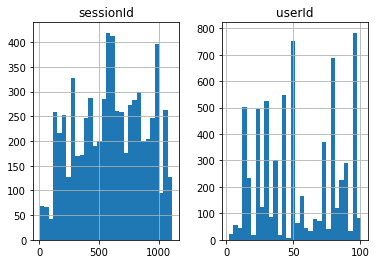

In [9]:
# Exploratory Data Analysis
# # insure unique primary key
unique = all(df.groupby(['userId','sessionId','itemInSession']).size()==1)
print(f'primary key is unique: {unique}')
# # check partition key distribution
hist = df[['userId', 'sessionId']].hist(bins=30)
hist

In [10]:
# Create Table
query = """
CREATE TABLE IF NOT EXISTS user_song (
userId INT,
sessionId INT,
itemInSession INT,
artist TEXT,
song TEXT,
firstName TEXT,
lastName TEXT,
PRIMARY KEY ((userId, sessionId), itemInSession)
)
"""
session.execute(query)

In [11]:
# Insert Data
query = """
INSERT INTO user_song
(userId, sessionId, itemInSession, artist, song, firstName, lastName)
VALUES (%s, %s, %s, %s, %s, %s, %s)
"""
for _, line in df.iterrows():
    session.execute(query, (line.userId, line.sessionId, line.itemInSession, line.artist, line.song, line.firstName, line.lastName))

Verify that for userId=10 and sessionId=182 returns 4 rows that are sorted by itemInSession
- itemInSession: 0; artist: Down To The Bone; song: Keep On Keepin' On; firstName: Sylvie; lastName: Cruz
- itemInSession: 1; artist: Three Drives; song: Greece 2000; firstName: Sylvie; lastName: Cruz
- itemInSession: 2; artist: Sebastien Tellier; song: Kilometer; firstName: Sylvie; lastName: Cruz
- itemInSession: 3; artist: Lonnie Gordon; song: Catch You Baby (Steve Pitron & Max Sanna Radio Edit); firstName: Sylvie; lastName: Cruz

In [12]:
# Verify Answer
userId = 10
sessionId = 182
query = """
SELECT itemInSession, artist, song, firstName, lastName
FROM user_session
WHERE userId=%s AND sessionId=%s
"""
rows = session.execute(query, (userId, sessionId))
for row in rows:
    print(f'itemInSession: {row.iteminsession}; artist: {row.artist}; song: {row.song}; firstName: {row.firstname}; lastName: {row.lastname}')

InvalidRequest: Error from server: code=2200 [Invalid query] message="unconfigured table user_session"

### 3. Give me every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'

A table named song_history is created using:
1. song as the partition key (in this case, distribution doesn't appear great)
2. userId as the clustering column

Note that the primary key is not unique in this case, so records will be overwritten if song and useId is the same. It is assumed this is not an issue since it still answers the question.

In [ ]:
# Exploratory Data Analysis
# # check unique primary key
unique = all(df.groupby(['song','userId']).size()==1)
print(f'primary key is unique: {unique}')
# # check partition key distribution
hist = df[['song', 'userId']].hist(bins=30)
hist

In [ ]:
# Create Table
query = """
CREATE TABLE IF NOT EXISTS song_history (
song TEXT,
userId INT,
firstName TEXT,
lastName TEXT,
PRIMARY KEY (song, userId)
)
"""
session.execute(query)

In [ ]:
# Insert Data
query = """
INSERT INTO song_history 
(song, userId, firstName, lastName)
VALUES (%s, %s, %s, %s)
"""
for _, line in df.iterrows():
    session.execute(query, (line.song, line.userId, line.firstName, line.lastName))

Verify that for the song 'All Hands Against Hist Own' 3 users are returned. These are sorted by userId although this was not a requirement.
- firstName: Jacqueline; lastName: Lynch
- firstName: Tegan; lastName: Levine
- firstName: Sara; lastName: Johnson

In [ ]:
# Verify Answer
song = 'All Hands Against His Own'
query = """
SELECT firstName, lastName
FROM song_users
WHERE song=%s
"""
rows = session.execute(query, (song,))
for row in rows:
    print(f'firstName: {row.firstname}; lastName: {row.lastname}')

### Drop the tables before closing out the sessions

In [ ]:
session.execute('DROP TABLE session_song')
session.execute('DROP TABLE user_song')
session.execute('DROP TABLE song_history')

### Close the session and cluster connection¶

In [ ]:
session.shutdown()
cluster.shutdown()